# CUNEF MUCD 2022/2023

# Machine Learning
# Análisis de Fraude¶

### Autores:
- Gozde Yazganoglu
- Irma Sanchez


# Importación de Librerías


In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss

from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')
from aux_func import evaluate_model, cargar_modelo

# Cargo de los Datos y Processor

In [9]:
xtrain = pd.read_parquet("../data/processed/xtrain.parquet")
ytrain = pd.read_parquet("../data/processed/ytrain.parquet")
xtest = pd.read_parquet("../data/processed/xtest.parquet")
ytest = pd.read_parquet("../data/processed/ytest.parquet")

In [6]:
#Cargamos pipeline preprocesado
preprocessor = cargar_modelo('../models/preprocessor.pickle')

# RANDOM FOREST

El algoritmo de bosque aleatorio es una extensión de bagging, ya que utiliza tanto el bagging como la Feature randomness para crear un bosque de árboles de decisión no correlacionado. La Feature randomness, genera un subconjunto aleatorio de características, lo que garantiza una baja correlación entre los árboles de decisión. Esta es una diferencia clave entre los árboles de decisión y el Random Forest.

In [11]:
clf_rf = Pipeline(steps=[
    ('preprocesador', preprocessor), 
    
    ('clasificador', RandomForestClassifier(n_jobs=-1, random_state=0))])

In [12]:
clf_rf.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['step', 'amount',
                                                   'connection_time',
                                                   'oldbalanceOrg', 'age',
                                                   'newbalanceOrig',
                                                   'user_number',
                                                   'user_connections',
                                                   'security_alert',
                                                   'oldbalanceDest',
      

In [13]:
ypred = clf_rf.predict(xtest)
ypred_proba = clf_rf.predict_proba(xtest)
evaluate_model(ytest,ypred, ypred_proba)

ROC-AUC score of the model: 0.9815634416539184
Accuracy of the model: 0.999718665808359

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.99      0.75      0.85       228

    accuracy                           1.00    209715
   macro avg       1.00      0.87      0.93    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209486      1]
 [    58    170]]



In [14]:
with open('../models/model_RF.pickle', 'wb') as f:
    pickle.dump(clf_rf, f)

In [16]:
with open('../models/model_RF.pickle', 'rb') as f:
    clf_svm = pickle.load(f)

In [17]:
# Adjusting threshold
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.010000, G-Mean=0.972
ROC-AUC score of the model: 0.9815634416539184
Accuracy of the model: 0.9951124144672532

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.18      0.94      0.30       228

    accuracy                           1.00    209715
   macro avg       0.59      0.97      0.65    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[208475   1012]
 [    13    215]]



# Graficos

ROC CURVE

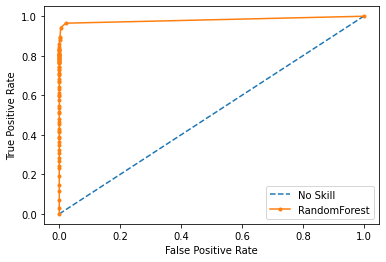

In [21]:
import matplotlib.pyplot as plt
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='RandomForest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [15]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.010000, G-Mean=0.972


PR CURVE

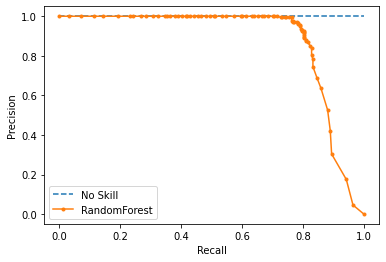

In [22]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(ytest, yhat)
# plot the roc curve for the model
no_skill = len(ytest[ytest==1]) / len(ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='RandomForest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.370000, F-Score=0.867


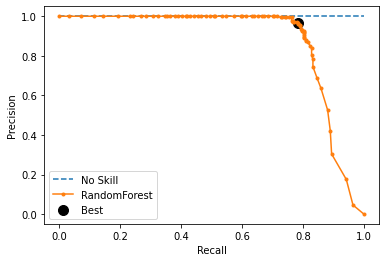

In [23]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(ytest[ytest==1]) / len(ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='RandomForest')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [18]:
# evaluate the model
score = f1_score(ytest, ypred)
print('F-Score: %.5f' % score)

F-Score: 0.85213


CUMULATIVE GAINS CURVE

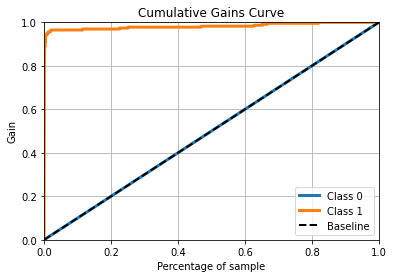

In [19]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(ytest, ypred_proba)
plt.show()

LIFT CURVE

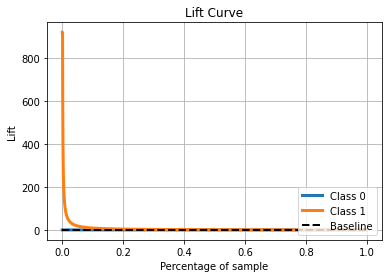

In [20]:
skplt.metrics.plot_lift_curve(ytest, ypred_proba)
plt.show()